In [1]:
import math
import os
import sys
import pandas as pd
sys.path.append("/home/weber/PycharmProjects/EXOTIC/src")
from statannot import add_stat_annotation

pd.options.mode.chained_assignment = None  # default='warn'
import multiprocessing
import parmap
import numpy as np
import collections
from tqdm import tqdm
import pandarallel
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=20, progress_bar=True)
# tqdm.pandas()
from pprint import pprint
from scipy.stats import zscore
from scipy import stats

import requests
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mc
from matplotlib.colors import LogNorm
import json
import matplotlib.ticker as mtick
from utils.utils import load_config_file

## YAML FILES CONFIG
yaml = load_config_file(config_file="/home/weber/PycharmProjects/EXOTIC/src/config.yaml")
exotic_files = yaml

import matplotlib.font_manager as font_manager

font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


In [ ]:
pd.options.display.max_rows = 100
df = pd.read_parquet('/gstock/EXOTIC/data/GENOMICS/RefSeq_corrected_by_GTEx_lite.parquet')
df.head(10)

In [38]:
tqdm.pandas()

## YAML FILES CONFIG
files = yaml

## JSON DICTS CONFIG
dicts = json.load(open("../src/EXOTIC_config.json"))

def build_file_exotic_score():

    # READ FILES
    # BIOMART
    biomart = pd.read_csv(
        files["EXOTIC"]["biomart_ensembl_hgnc_refseq"],
        compression="gzip",
        sep="\t",
        low_memory=False,
    )


    refseq = pd.read_parquet(
#         files["RefSeq"]["refseq_corrected_lite"],
        '/gstock/EXOTIC/data/GENOMICS/RefSeq_corrected_by_GTEx_with_variable.parquet'
    )
    refseq.columns = [c.replace("new_", "") for c in refseq.columns]

#     print(refseq)
    
    # FILTER REFSEQ => MI & Multi CDS
    refseq = refseq.loc[(refseq["mRNA_nb_total"] > 1) & (refseq["CDS_count"] > 1) & (refseq['Ratio_num'] < 1)]
    
    print(refseq.Gene.nunique())
    print(refseq[['Gene', 'ranges']].drop_duplicates().shape[0])
    
    
    biomart = (
        biomart[["Gene stable ID", "HGNC ID", "Gene name"]]
        .rename(
            {"Gene stable ID": "ENSG", "HGNC ID": "HGNC", "Gene name": "Gene"},
            axis=1,
        )
        .drop_duplicates()
    )
    biomart["HGNC"] = biomart["HGNC"].str.replace("HGNC:", "")

    # MERGE IDS
    refseq = pd.merge(refseq, biomart, on="Gene")
    print(refseq.Gene.nunique())
    print(refseq[['Gene', 'ranges']].drop_duplicates().shape[0])

    refseq = refseq.dropna(subset=["HGNC"])
    print(refseq.Gene.nunique())
    print(refseq[['Gene', 'ranges']].drop_duplicates().shape[0])

    # CONVERT DTYPE
    refseq["HGNC"] = refseq["HGNC"].astype(int)

    ## pext
    pext_refseq = pd.read_parquet(files['EXOTIC']["pext_refseq_path"])

    # SELECT MULTI-ISOFORM GENES
    multi_mrna_genes = refseq.loc[refseq["mRNA_nb_total"] > 1, "HGNC"].unique()

    # FILTER PEXT TO GET ONLY MULTI-ISO GENES
    pext_refseq["HGNC ID"] = pext_refseq["HGNC ID"].astype(int)
    pext_refseq = pext_refseq.loc[pext_refseq["HGNC ID"].isin(multi_mrna_genes)]

    # ADD COLUMSN TO PEXT
    pext_refseq = pd.merge(
        pext_refseq,
        refseq[["HGNC", "ranges", "Ratio_num", "mRNA_nb", "mRNA_nb_total"]],
        left_on=["HGNC ID", "Exon"],
        right_on=["HGNC", "ranges"],
    )
    pext_refseq["MAP"] = pext_refseq["symbol"] + "_" + pext_refseq["Exon"]

    key_number = 9

    # DROP DUPLICATES
    pext_refseq = pext_refseq.drop_duplicates().sort_values(by="MAP").reset_index(drop=True)
    print(pext_refseq.symbol.nunique())
    print(pext_refseq[['symbol', 'Exon']].drop_duplicates().shape[0])
    
    # RENAME COLUMNS & REORDER
    pext_refseq = pext_refseq.rename(dicts["convert_tissue_dict"], axis=1)

    pext_refseq = pext_refseq[
        [
            "symbol",
            "ensg",
            "HGNC",
            "Exon",
            "Ratio_num",
            "mRNA_nb",
            "mRNA_nb_total",
            "MAP",
            "mean_proportion",
            "Adipose - Subcutaneous",
            "Adipose - Visceral (Omentum)",
            "Adrenal Gland",
            "Artery - Aorta",
            "Artery - Coronary",
            "Artery - Tibial",
            "Bladder",
            "Brain - Amygdala",
            "Brain - Anterior cingulate cortex (BA24)",
            "Brain - Caudate (basal ganglia)",
            "Brain - Cerebellar Hemisphere",
            "Brain - Cerebellum",
            "Brain - Cortex",
            "Brain - Frontal Cortex (BA9)",
            "Brain - Hippocampus",
            "Brain - Hypothalamus",
            "Brain - Nucleus accumbens (basal ganglia)",
            "Brain - Putamen (basal ganglia)",
            "Brain - Spinal cord (cervical c-1)",
            "Brain - Substantia nigra",
            "Breast - Mammary Tissue",
            "Cells - Cultured fibroblasts",
            "Cells - EBV-transformed lymphocytes",
            "Cervix - Ectocervix",
            "Cervix - Endocervix",
            "Colon - Sigmoid",
            "Colon - Transverse",
            "Esophagus - Gastroesophageal Junction",
            "Esophagus - Mucosa",
            "Esophagus - Muscularis",
            "Fallopian Tube",
            "Heart - Atrial Appendage",
            "Heart - Left Ventricle",
            "Kidney - Cortex",
            "Liver",
            "Lung",
            "Minor Salivary Gland",
            "Muscle - Skeletal",
            "Nerve - Tibial",
            "Ovary",
            "Pancreas",
            "Pituitary",
            "Prostate",
            "Skin - Not Sun Exposed (Suprapubic)",
            "Skin - Sun Exposed (Lower leg)",
            "Small Intestine - Terminal Ileum",
            "Spleen",
            "Stomach",
            "Testis",
            "Thyroid",
            "Uterus",
            "Vagina",
            "Whole Blood",
        ]
    ]

    # ALTERNATIVE EXONS
    pext_refseq = pext_refseq.loc[pext_refseq["Ratio_num"] < 1].reset_index(drop=True)
    
    print(pext_refseq.symbol.nunique())
    print(pext_refseq[['symbol', 'Exon']].drop_duplicates().shape[0])

    # TODO : CHECK HOW TO HANDLE UNEXPRESSED AND FULLY EXPRESSED (0 & 1 MEAN PROP)
    ### WARNING FLAG
    # UNEXPRESSED AND FULLY EXPRESSED EXONS
    pext_refseq = pext_refseq.loc[(pext_refseq["mean_proportion"] < 1)].reset_index(drop=True)
    
    print(pext_refseq.symbol.nunique())
    print(pext_refseq[['symbol', 'Exon']].drop_duplicates().shape[0])

    # HANDLE NAN VALUES

    pext_refseq = pext_refseq.dropna(subset=list(pext_refseq.columns[key_number:]), how="all")


    # EXOTIC SIGMOID FUNCTION APPLIED TO ZSCORE
#     def transform(r):
# #         print(r)
#         def sigmoid(x):
#             return 1 / (1 + np.exp(-x))

#         vfunc = np.vectorize(sigmoid)
#         if r.isnull().values.any():
#             return pd.Series(vfunc(zscore(r.dropna())), index=r.dropna().index)

#         else:
#             return pd.Series(vfunc(zscore(r)), index=r.index)

#     # EXOTIC SIGMOID FUNCTION APPLIED TO ZSCORE
#     def transform_test(x):
# #         print(x)
#         x = x.dropna()
#         def sigmoid(s_x):
#             return 1 / (1 + np.exp(-s_x))

#         vfunc = np.vectorize(sigmoid)
# #         if x.isnull().values.any():
# # #             return pd.Series(vfunc([round(e_z * np.abs(e_x - np.median([e for i,e in enumerate(x) if i != j])), 3) for (j, e_x), e_z in zip(enumerate(x.dropna()), zscore(x.dropna()))]), index=x.dropna().index)

# #         else:
#         result = vfunc([round(e_z * np.abs(e_x - np.median([e for i,e in enumerate(x) if i != j])), 3) for (j, e_x), e_z in zip(enumerate(x), zscore(x))])
#         return pd.Series(result, index=x.index)



    def main_transform(x):
        x = x.dropna()

        def sigmoid(e):
            return 1 / (1 + math.exp(-e))
        vsigmoid = np.vectorize(sigmoid)

        def norm(e):
            return (2*((e - 0)/(1 - 0)))-1
        vnorm = np.vectorize(norm)

        def remove_value(x, i):
            return [sub_e for j, sub_e in enumerate(x) if j != i]

        def modif_zscore(x):
            return [e_z * np.abs(e_x - np.mean([e for i,e in enumerate(x) if i != j])) for (j, e_x), e_z in zip(enumerate(x), zscore(x))]
#         vmodif = np.vectorize(modif_zscore)

        z_score_x = modif_zscore(x)

        z_score_x = vsigmoid(z_score_x)
        z_score_x = vnorm(z_score_x)

#         z_score_x = [round(e, 3) for e in z_score_x]
        return pd.Series(z_score_x, index=x.index)

    
    # BUILD MATRIX WITH Z-SCORE + SIGMOID
    z_df = pext_refseq[pext_refseq.columns[key_number:]].progress_apply(lambda r: main_transform(r), axis=1)
#     df = pext_refseq.loc[pext_refseq['MAP'] == 'AASDH_57209001-57209132', pext_refseq.columns[key_number:]]
#     z_df = df.progress_apply(lambda r: transform_test(r), axis=1)
    z_df_processed = z_df.copy()
    z_df.columns = list(pext_refseq.columns[key_number:])
    tissue_cols = list(z_df.columns)
    
    # COMPUTE MIN & MAX EXOTIC COLS
    for stat in [min, max]:
        str_stat = stat.__name__
#         print(str_stat)
    
        if str_stat == 'min':
            exotic_stat_convert = 'down'

        elif str_stat == 'max':
            exotic_stat_convert = 'up'
        
        def test_func(r, stat):
            try : 
                return stat(r.dropna())
            except:
                pass
#                 print(r)
                
        
        z_df_processed['EXOTIC_{}'.format(exotic_stat_convert)] = z_df.apply(lambda r: test_func(r, stat), axis=1)
        
#         # COMPUTE BINS
#         r = np.arange(0.5,1.05,0.05)
#         bins = r
#         labels = bins.copy()
#         labels_ratio = [str(round(labels[j], 3)) + " - " + str(round(labels[j + 1], 3)) for j in range(len(labels) - 1)]

#         # COMPUTE BINS
#         r = np.arange(0.5,1.01,0.1)
#         bins_lite = r
#         labels_lite = bins_lite.copy()
#         labels_ratio_lite = [str(round(labels_lite[j], 2)) + " - " + str(round(labels_lite[j + 1], 2)) for j in range(len(labels_lite) - 1)]


#         # COMPUTE BINS COLUMNS
#         z_df_processed["EXOTIC_bins_{}".format(exotic_stat_convert)] = pd.cut(z_df_processed["EXOTIC_{}".format(exotic_stat_convert)], bins=bins, labels=labels_ratio, include_lowest=True)
#         z_df_processed["EXOTIC_bins_lite_{}".format(exotic_stat_convert)] = pd.cut(z_df_processed["EXOTIC_{}".format(exotic_stat_convert)], bins=bins_lite, labels=labels_ratio_lite, include_lowest=True)

#         z_df_processed['EXOTIC_tissues_{}'.format(exotic_stat_convert)] = z_df_processed.apply(lambda r: [tissue_cols[j] for j, e in enumerate(r) if j < 53 and e == r['EXOTIC_{}'.format(exotic_stat_convert)]], axis=1)

        
#         if str_stat == 'min':
#             exotic_stat_convert = 'down'
#             z_df_processed['EXOTIC_{}'.format(exotic_stat_convert)] = 1 - z_df_processed['EXOTIC_{}'.format(exotic_stat_convert)]
#             z_df_processed["EXOTIC_bins_{}".format(exotic_stat_convert)] = pd.cut(z_df_processed["EXOTIC_{}".format(exotic_stat_convert)], bins=bins, labels=labels_ratio, include_lowest=True)
#             z_df_processed["EXOTIC_bins_lite_{}".format(exotic_stat_convert)] = pd.cut(z_df_processed["EXOTIC_{}".format(exotic_stat_convert)], bins=bins_lite, labels=labels_ratio_lite, include_lowest=True)
#         pprint(z_df_processed.to_dict())
        
        # TMP CONCAT EXOTIC SCORE & PEXT VALUES
    ### WARNING FLAG
    # TODO : modify to delete pext part after defining thresholds
    concat_df = pd.concat(
        [
            pext_refseq[pext_refseq.columns[:key_number]].reset_index(drop=True),
            z_df_processed.reset_index(drop=True),
#             pext_refseq[pext_refseq.columns[key_number:]].add_suffix("_pextvalue").reset_index(drop=True),
        ],
        axis=1,
    )
    
    
    df = pd.read_parquet('/gstock/EXOTIC/data/GENOMICS/RefSeq_corrected_by_GTEx_with_variable.parquet')
    concat_df = pd.merge(concat_df.drop(['Ratio_num'], axis=1), df, left_on=['symbol', 'Exon'], right_on=['Gene', 'ranges'])

    
#     print(concat_df)

#     # REMOVE DUPLICATES
#     concat_df = concat_df.drop_duplicates(subset=['MAP']).sort_values(by="MAP").reset_index(drop=True)

#     # OUTPUT INTERMEDIATE FILE
    print(concat_df.columns)

    concat_df.to_parquet("/gstock/EXOTIC/data/EXOTIC/EXOTIC_modified_zscore_mean_prop_corrected_with_variable.parquet")
# #     concat_df.to_excel(self.exotic_files["exotic_path"].replace("parquet", "xlsx"))
    return concat_df
#     print(refseq.Gene.nunique())
#     print(refseq[['Gene', 'ranges']].drop_duplicates().shape[0])
#     print(pext_refseq.symbol.nunique())
#     print(pext_refseq.MAP.nunique())
#     print(concat_df)

    
exotic = build_file_exotic_score()
exotic

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


7039
36310
7004
36100
7004
36100


  0%|          | 37/29251 [00:00<01:20, 364.33it/s]

6555
29633
6555
29633
6440
29224


100%|██████████| 29251/29251 [01:23<00:00, 349.67it/s]


Index(['symbol', 'ensg', 'HGNC', 'Exon', 'mRNA_nb', 'mRNA_nb_total', 'MAP',
       'mean_proportion', 'Adipose - Subcutaneous',
       'Adipose - Visceral (Omentum)', 'Adrenal Gland', 'Artery - Aorta',
       'Artery - Coronary', 'Artery - Tibial', 'Bladder', 'Brain - Amygdala',
       'Brain - Anterior cingulate cortex (BA24)',
       'Brain - Caudate (basal ganglia)', 'Brain - Cerebellar Hemisphere',
       'Brain - Cerebellum', 'Brain - Cortex', 'Brain - Frontal Cortex (BA9)',
       'Brain - Hippocampus', 'Brain - Hypothalamus',
       'Brain - Nucleus accumbens (basal ganglia)',
       'Brain - Putamen (basal ganglia)', 'Brain - Spinal cord (cervical c-1)',
       'Brain - Substantia nigra', 'Breast - Mammary Tissue',
       'Cells - Cultured fibroblasts', 'Cells - EBV-transformed lymphocytes',
       'Cervix - Ectocervix', 'Cervix - Endocervix', 'Colon - Sigmoid',
       'Colon - Transverse', 'Esophagus - Gastroesophageal Junction',
       'Esophagus - Mucosa', 'Esophagus - Muscu

,symbol,ensg,HGNC,Exon,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,Adipose - Visceral (Omentum),...,new_mRNA_gene,new_mRNA_nb_total,Ratio,CDS_start,CDS_stop,Share,Length,Ratio_num,Const_Alt,CDS_count
0,A2ML1,ENSG00000166535,23336,8975248-8975309,1,2,A2ML1_8975248-8975309,0.69514,0.156704,0.156704,...,"[NM_144670, NM_001282424]",2,1/2,8975248,8975309,False,61,0.500000,Alt,36
1,A2ML1,ENSG00000166535,23336,8975778-8975961,1,2,A2ML1_8975778-8975961,0.69514,0.156704,0.156704,...,"[NM_144670, NM_001282424]",2,1/2,8975778,8975961,False,183,0.500000,Alt,36
2,A2ML1,ENSG00000166535,23336,8976316-8976478,1,2,A2ML1_8976316-8976478,0.69514,0.156704,0.156704,...,"[NM_144670, NM_001282424]",2,1/2,8976316,8976478,False,162,0.500000,Alt,36
3,A2ML1,ENSG00000166535,23336,8982323-8982375,1,2,A2ML1_8982323-8982375,0.69514,0.156704,0.156704,...,"[NM_144670, NM_001282424]",2,1/2,8982323,8982375,False,52,0.500000,Alt,36
4,A2ML1,ENSG00000166535,23336,8987258-8987278,1,2,A2ML1_8987258-8987278,0.69514,0.156704,0.156704,...,"[NM_144670, NM_001282424]",2,1/2,8987258,8987278,False,20,0.500000,Alt,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29295,ZXDC,ENSG00000070476,28160,126158475-126158570,1,2,ZXDC_126158475-126158570,0.20989,0.000470,0.009736,...,"[NM_025112, NM_001040653]",2,1/2,126158475,126158570,False,95,0.500000,Alt,11
29296,ZXDC,ENSG00000070476,28160,126160608-126160789,1,2,ZXDC_126160608-126160789,0.20989,0.000470,0.009736,...,"[NM_025112, NM_001040653]",2,1/2,126160608,126160789,False,181,0.500000,Alt,11
29297,ZXDC,ENSG00000070476,28160,126178496-126178580,1,2,ZXDC_126178496-126178580,0.20989,0.000470,0.009736,...,"[NM_025112, NM_001040653]",2,1/2,126178496,126178580,False,84,0.500000,Alt,11
29298,ZXDC,ENSG00000070476,28160,126180378-126181063,1,2,ZXDC_126180378-126181063,0.34803,0.030669,0.014999,...,"[NM_025112, NM_001040653]",2,1/2,126180378,126181063,False,685,0.500000,Alt,11


In [47]:
exotic = pd.read_parquet("/gstock/EXOTIC/data/EXOTIC/EXOTIC_modified_zscore.parquet")
exotic

,symbol,ensg,HGNC,Exon,Ratio_num,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,...,Thyroid,Uterus,Vagina,Whole Blood,EXOTIC_down,EXOTIC_bins_down,EXOTIC_tissues_down,EXOTIC_up,EXOTIC_bins_up,EXOTIC_tissues_up
0,A2ML1,ENSG00000166535,23336,8975248-8975309,0.500000,1,2,A2ML1_8975248-8975309,0.69514,0.578349,...,0.578349,0.441765,0.500000,0.578349,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O..."
1,A2ML1,ENSG00000166535,23336,8975778-8975961,0.500000,1,2,A2ML1_8975778-8975961,0.69514,0.578349,...,0.578349,0.441765,0.500000,0.578349,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O..."
2,A2ML1,ENSG00000166535,23336,8976316-8976478,0.500000,1,2,A2ML1_8976316-8976478,0.69514,0.578349,...,0.578349,0.441765,0.500000,0.578349,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O..."
3,A2ML1,ENSG00000166535,23336,8982323-8982375,0.500000,1,2,A2ML1_8982323-8982375,0.69514,0.578349,...,0.578349,0.441765,0.500000,0.578349,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O..."
4,A2ML1,ENSG00000166535,23336,8987258-8987278,0.500000,1,2,A2ML1_8987258-8987278,0.69514,0.578349,...,0.578349,0.441765,0.500000,0.578349,0.713205,0.7 - 0.75,[Brain - Cerebellar Hemisphere],0.578349,0.55 - 0.6,"[Adipose - Subcutaneous, Adipose - Visceral (O..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24288,ZXDC,ENSG00000070476,28160,126158475-126158570,0.500000,1,2,ZXDC_126158475-126158570,0.20989,0.500250,...,0.501750,0.500500,0.508499,0.495250,0.542398,0.5 - 0.55,[Brain - Nucleus accumbens (basal ganglia)],0.574443,0.55 - 0.6,[Muscle - Skeletal]
24289,ZXDC,ENSG00000070476,28160,126160608-126160789,0.500000,1,2,ZXDC_126160608-126160789,0.20989,0.500250,...,0.501750,0.500500,0.508499,0.495250,0.542398,0.5 - 0.55,[Brain - Nucleus accumbens (basal ganglia)],0.574443,0.55 - 0.6,[Muscle - Skeletal]
24290,ZXDC,ENSG00000070476,28160,126178496-126178580,0.500000,1,2,ZXDC_126178496-126178580,0.20989,0.500250,...,0.501750,0.500500,0.508499,0.495250,0.542398,0.5 - 0.55,[Brain - Nucleus accumbens (basal ganglia)],0.574443,0.55 - 0.6,[Muscle - Skeletal]
24291,ZXDC,ENSG00000070476,28160,126180378-126181063,0.500000,1,2,ZXDC_126180378-126181063,0.34803,0.515245,...,0.497250,0.505250,0.505750,0.441272,0.558728,0.55 - 0.6,[Whole Blood],0.606828,0.6 - 0.65,[Artery - Tibial]


In [48]:
exotic.loc[exotic['EXOTIC_up'] > 0.8, 'MAP'].nunique()

1493

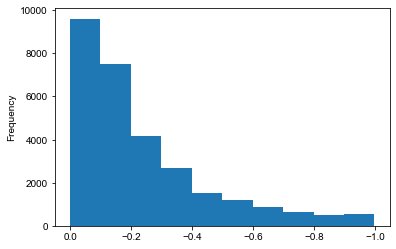

In [42]:
f, ax  = plt.subplots()
exotic.EXOTIC_down.plot.hist(ax=ax)
ax.invert_xaxis()

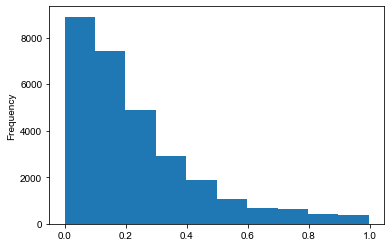

In [40]:
exotic.EXOTIC_up.plot.hist()

In [ ]:
exotic.columns

In [15]:
exotic.loc[50].to_dict()

{'symbol': 'ABCA8',
 'ensg': 'ENSG00000141338',
 'HGNC': 38,
 'Exon': '66878845-66878860',
 'mRNA_nb': 2,
 'mRNA_nb_total': 3,
 'MAP': 'ABCA8_66878845-66878860',
 'mean_proportion': 0.5476800000000001,
 'Adipose - Subcutaneous': 0.2414986787505069,
 'Adipose - Visceral (Omentum)': 0.2694401048036039,
 'Adrenal Gland': 0.26651167170300516,
 'Artery - Aorta': 0.27621058558320777,
 'Artery - Coronary': 0.26895778821469163,
 'Artery - Tibial': 0.2789240749258255,
 'Bladder': 0.2638946604005745,
 'Brain - Amygdala': 0.31836801606497156,
 'Brain - Anterior cingulate cortex (BA24)': 0.2926938606278824,
 'Brain - Caudate (basal ganglia)': 0.27926986425141376,
 'Brain - Cerebellar Hemisphere': 0.36151276297675383,
 'Brain - Cerebellum': 0.2840802947590997,
 'Brain - Cortex': 0.24322589123980154,
 'Brain - Frontal Cortex (BA9)': 0.30469319577092047,
 'Brain - Hippocampus': 0.28269615995884756,
 'Brain - Hypothalamus': 0.30676914476331607,
 'Brain - Nucleus accumbens (basal ganglia)': 0.297696316

In [ ]:
df = pd.read_parquet('/gstock/EXOTIC/data/GENOMICS/RefSeq_corrected_by_GTEx_with_variable.parquet')

test = pd.merge(exotic.drop(['Ratio_num'], axis=1), df, left_on=['symbol', 'Exon'], right_on=['Gene', 'ranges'])
test

In [ ]:
test.columns

In [ ]:
pd.options.display.max_rows = 100
pd.DataFrame(exotic.loc[3404].T)

In [ ]:
files["RefSeq"]["refseq_corrected_lite"]

In [ ]:
refseq = pd.read_parquet(
    files["RefSeq"]["refseq_corrected_lite"],
)
refseq.columns = [c.replace("new_", "") for c in refseq.columns]

#     print(refseq)

# FILTER REFSEQ => MI & Multi CDS
# refseq = refseq.loc[(refseq["mRNA_nb_total"] > 1) & (refseq["CDS_count"] > 1) & (refseq['Ratio_num'] < 1)]
refseq

In [ ]:
refseq.loc[refseq['Gene'] == 'ERBB3']

In [ ]:
exotic.loc[exotic['symbol'] == 'TGFBR1'][['Adipose - Visceral (Omentum)', 'Adrenal Gland', 'Artery - Aorta',
       'Artery - Coronary', 'Artery - Tibial', 'Bladder', 'Brain - Amygdala',
       'Brain - Anterior cingulate cortex (BA24)',
       'Brain - Caudate (basal ganglia)', 'Brain - Cerebellar Hemisphere',
       'Brain - Cerebellum', 'Brain - Cortex', 'Brain - Frontal Cortex (BA9)',
       'Brain - Hippocampus', 'Brain - Hypothalamus',
       'Brain - Nucleus accumbens (basal ganglia)',
       'Brain - Putamen (basal ganglia)', 'Brain - Spinal cord (cervical c-1)',
       'Brain - Substantia nigra', 'Breast - Mammary Tissue',
       'Cells - Cultured fibroblasts', 'Cells - EBV-transformed lymphocytes',
       'Cervix - Ectocervix', 'Cervix - Endocervix', 'Colon - Sigmoid',
       'Colon - Transverse', 'Esophagus - Gastroesophageal Junction',
       'Esophagus - Mucosa', 'Esophagus - Muscularis', 'Fallopian Tube',
       'Heart - Atrial Appendage', 'Heart - Left Ventricle', 'Kidney - Cortex',
       'Liver', 'Lung', 'Minor Salivary Gland', 'Muscle - Skeletal',
       'Nerve - Tibial', 'Ovary', 'Pancreas', 'Pituitary', 'Prostate',
       'Skin - Not Sun Exposed (Suprapubic)', 'Skin - Sun Exposed (Lower leg)',
       'Small Intestine - Terminal Ileum', 'Spleen', 'Stomach', 'Testis',
       'Thyroid', 'Uterus', 'Vagina', 'Whole Blood']].to_dict()

In [ ]:
exotic.loc[exotic['EXOTIC_up'] > 0.99]

In [ ]:
exotic.loc[(exotic['EXOTIC_down'] > 0.8) & (exotic['EXOTIC_up'] > 0.8)]

In [ ]:
exotic.loc[exotic['EXOTIC_up'].isna() == True]

In [ ]:
exotic.loc[exotic['MAP'] == "ARPP21_35725513-35725521"].to_dict()

In [ ]:
pext_refseq = pd.read_parquet(files['EXOTIC']["pext_refseq_path"])
pext_refseq["MAP"] = pext_refseq["symbol"] + "_" + pext_refseq["Exon"]


pext_refseq.loc[pext_refseq['MAP'] == 'ZNF257_22270781-22272244'].to_dict()

In [ ]:
exotic.loc[exotic['symbol'] == 'ERBB2'].to_dict()

In [ ]:
exotic.EXOTIC_tissues_up

In [ ]:
len_tissue_cols = 53

for j,e in enumerate(exotic.loc[0][:len_tissue_cols+1]):
    print(j,e)

In [ ]:
exotic.to_parquet("/gstock/EXOTIC/data/EXOTIC/EXOTIC_modified_zscore.parquet")


In [ ]:
exotic.symbol.nunique()

In [ ]:
exotic = pd.read_parquet("/gstock/EXOTIC/data/EXOTIC/EXOTIC_modified_zscore_mean_prop_corrected.parquet")
exotic


In [ ]:
exotic.loc[exotic['symbol'] == 'CREB1']

In [ ]:
exotic.loc[586].to_dict()

In [ ]:
exotic['EXOTIC_bins_min'].value_counts()

In [ ]:
exotic['EXOTIC_bins_max'].value_counts()

In [ ]:
max(exotic.EXOTIC_down)

In [ ]:
pd.read_excel('/gstock/EXOTIC/data/EXOTIC/circular_barplot_total.xlsx')

In [ ]:
up = exotic.loc[exotic['EXOTIC_up'] > 0.8, ['EXOTIC_tissues_up']].explode('EXOTIC_tissues_up').value_counts()
up.name = 'Up'
up = pd.DataFrame(up)
down = exotic.loc[exotic['EXOTIC_down'] > 0.8, ['EXOTIC_tissues_down']].explode('EXOTIC_tissues_down').value_counts()
down.name = 'Down'
down = pd.DataFrame(down)
concat_up_down = pd.concat([down, up], axis=1).fillna(0).round(0)
concat_up_down['Sum'] = concat_up_down.sum(axis=1)
concat_up_down['log_value'] = concat_up_down['Sum'].apply(np.log10)
concat_up_down = concat_up_down.reset_index().rename({'level_0' : 'Tissue'}, axis=1)

old_sun_excel = pd.read_excel('/gstock/EXOTIC/data/EXOTIC/circular_barplot_total.xlsx')

concat_up_down = pd.merge(old_sun_excel[['Tissue', 'group', 'Abbrev', 'Color']], concat_up_down, on='Tissue')

concat_up_down.to_excel('/gstock/EXOTIC/data/EXOTIC/exotic_sun_tissues.xlsx', index=False)

concat_up_down

# exotic[['EXOTIC_tissues_up']]

In [ ]:
ridge_up = exotic[['EXOTIC_tissues_up', 'EXOTIC_up', 'MAP', 'symbol']].explode('EXOTIC_tissues_up')
ridge_up.columns = ['Tissue', 'EXOTIC_up', 'MAP', 'symbol']
ridge_up.to_excel('/gstock/EXOTIC/data/EXOTIC/EXOTIC_up_Rdata.xlsx', index=False)

ridge_down = exotic[['EXOTIC_tissues_down', 'EXOTIC_down', 'MAP', 'symbol']].explode('EXOTIC_tissues_down')
ridge_down.columns = ['Tissue', 'EXOTIC_down', 'MAP', 'symbol']
ridge_down.to_excel('/gstock/EXOTIC/data/EXOTIC/EXOTIC_down_Rdata.xlsx', index=False)

In [ ]:
ridge_down

In [57]:
exotic['EXOTIC_bins_down'].value_counts()

0.5 - 0.55    8582
0.55 - 0.6    7226
0.6 - 0.65    4053
0.65 - 0.7    2585
0.7 - 0.75    1494
0.75 - 0.8    1159
0.8 - 0.85     814
0.85 - 0.9     605
0.95 - 1.0     529
0.9 - 0.95     469
Name: EXOTIC_bins_down, dtype: int64

In [58]:
exotic['EXOTIC_bins_down'].value_counts().sum()

27516

In [ ]:
exotic.loc[exotic['EXOTIC_up'] > 0.7, 'MAP'].nunique()

(-0.25, 9.65)
Rectangle(xy=(0, 0), width=-0.4, height=8582, angle=0)
Rectangle(xy=(1, 0), width=-0.4, height=7226, angle=0)
Rectangle(xy=(2, 0), width=-0.4, height=4053, angle=0)
Rectangle(xy=(3, 0), width=-0.4, height=2585, angle=0)
Rectangle(xy=(4, 0), width=-0.4, height=1494, angle=0)
Rectangle(xy=(5, 0), width=-0.4, height=1159, angle=0)
Rectangle(xy=(6, 0), width=-0.4, height=814, angle=0)
Rectangle(xy=(7, 0), width=-0.4, height=605, angle=0)
Rectangle(xy=(8, 0), width=-0.4, height=469, angle=0)
Rectangle(xy=(9, 0), width=-0.4, height=529, angle=0)
Rectangle(xy=(0, 0), width=0.4, height=8728, angle=0)
Rectangle(xy=(1, 0), width=0.4, height=6906, angle=0)
Rectangle(xy=(2, 0), width=0.4, height=4510, angle=0)
Rectangle(xy=(3, 0), width=0.4, height=2708, angle=0)
Rectangle(xy=(4, 0), width=0.4, height=1721, angle=0)
Rectangle(xy=(5, 0), width=0.4, height=954, angle=0)
Rectangle(xy=(6, 0), width=0.4, height=649, angle=0)
Rectangle(xy=(7, 0), width=0.4, height=605, angle=0)
Rectangle(x

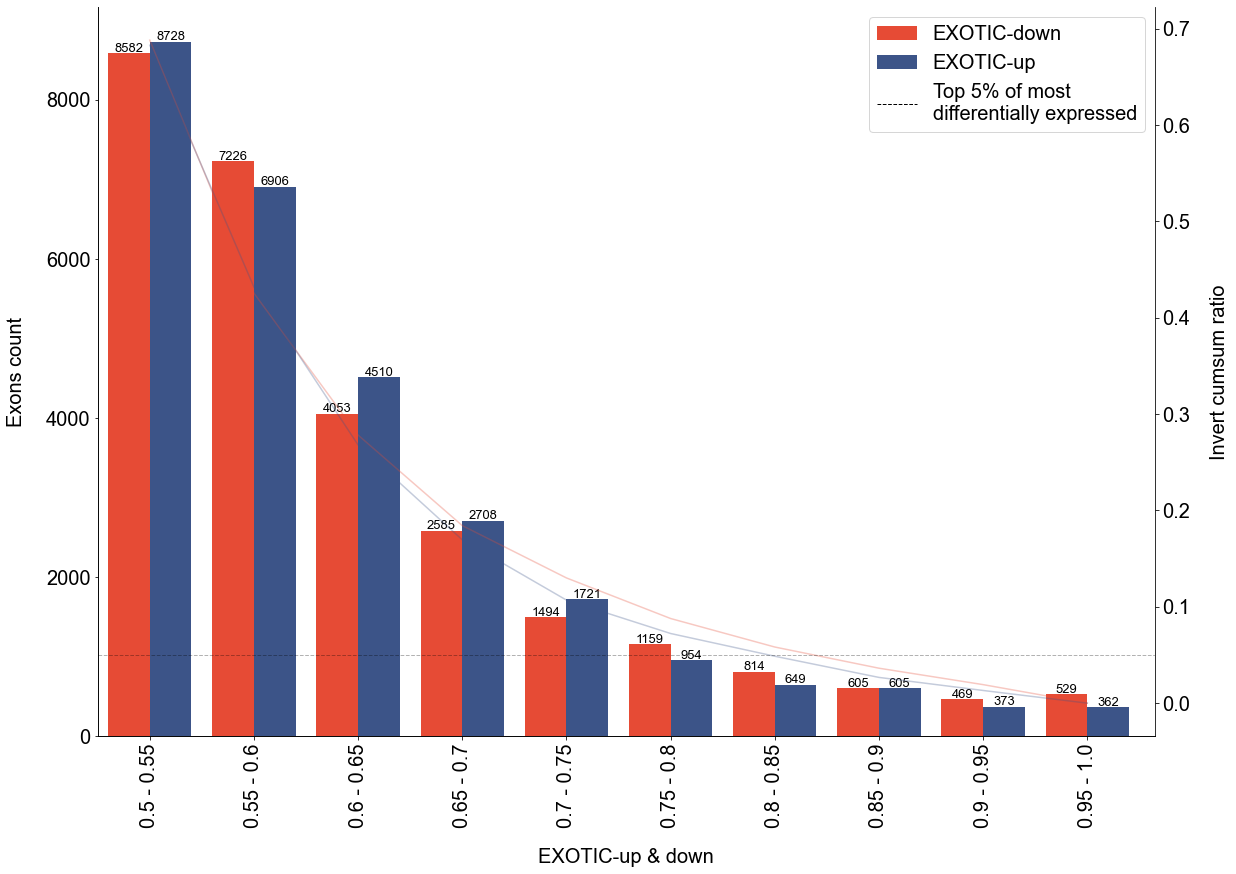

In [53]:
def show_values_on_bars(axs, i=0, fontsize=13, rotation=0):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + (p.get_height()) + 20
            if i == 0:
                value = "{:.0f}".format(p.get_height())
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            ax.text(_x, _y, str(round(int(value), 0)), ha="center", fontsize=fontsize, rotation=rotation, color='black')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


exotic = pd.read_parquet("/gstock/EXOTIC/data/EXOTIC/EXOTIC_modified_zscore_mean_prop_corrected.parquet")
        
        
        
plt.rcParams.update({'font.size': 20})

f, ax = plt.subplots(figsize=(16,12))        
exotic['EXOTIC_bins_down'].value_counts().sort_index().plot.bar(alpha=1, color='#E64B35FF', width=-0.4, align='edge')
# exotic.EXOTIC_median.plot.hist(alpha=0.3, color='g', rwidth=0.8)
exotic['EXOTIC_bins_up'].value_counts().sort_index().plot.bar(alpha=1, width=0.4, color='#3C5488FF', align='edge')
plt.legend()
# ax2.set_ylim(ax.get_ylim())
print(ax.get_xlim())
ax.set_xlim(-0.5,9.65)

show_values_on_bars(ax)
# plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9)
plt.tight_layout()

ax.set_xlabel('EXOTIC-up & down', labelpad=20)
ax.set_ylabel('Exons count', labelpad=20)
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
L=plt.legend()
L.get_texts()[0].set_text('EXOTIC-down')
L.get_texts()[1].set_text('EXOTIC-up')
# ax.set_xticks(np.arange(0.5,1,0.05))
print(list(ax.get_xticklabels()))
# ax.set_xticklabels([str(e) for e in np.arange(0.5,1.05,0.05)])

ax2 = ax.twinx()

tmp_cumsum_df = pd.concat([pd.DataFrame(exotic['EXOTIC_bins_down'].value_counts().sort_index()), pd.DataFrame(exotic['EXOTIC_bins_up'].value_counts().sort_index())], axis=1)
tmp_cumsum_df['Cumsum_down'] = (tmp_cumsum_df['EXOTIC_bins_down'].sum() - tmp_cumsum_df['EXOTIC_bins_down'].cumsum()) / tmp_cumsum_df['EXOTIC_bins_down'].sum()
tmp_cumsum_df['Cumsum_up'] = (tmp_cumsum_df['EXOTIC_bins_up'].sum() - tmp_cumsum_df['EXOTIC_bins_up'].cumsum()) / tmp_cumsum_df['EXOTIC_bins_up'].sum()
tmp_cumsum_df.Cumsum_down.plot.line(color='#E64B35FF', alpha=0.3, ax=ax2)
tmp_cumsum_df.Cumsum_up.plot.line(color='#3C5488FF', alpha=0.3, ax=ax2)
# ax2.spines['right'].set_linewidth(0)
ax2.spines['top'].set_linewidth(0)
axh = ax2.axhline(0.05, color='black', linestyle='--', lw=1, alpha=0.3)
ax2.set_ylabel('Invert cumsum ratio', labelpad=20)

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D   

handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()

plt.legend(handles=handles + [ Line2D([0], [0], color='black', lw=1, ls='--')], labels=['EXOTIC-down', 'EXOTIC-up', 'Top 5% of most\ndifferentially expressed'])


# # COMPUTE BINS
# bins = np.arange(min(exotic.EXOTIC_down), max(exotic.EXOTIC_up)+0.05, 0.05)
# labels = bins.copy()
# labels_ratio = [str(round(labels[j], 3)) + " - " + str(round(labels[j + 1], 3)) for j in range(len(labels) - 1)]


# xticks = ax.set_xticks(np.arange(min(exotic.EXOTIC_down), max(exotic.EXOTIC_up)+0.05, 0.05))
# ax.set_xticks(ax.get_xticks()[:-1])
# plt.xlim(0.45,1)



In [ ]:
tmp_cumsum_df_tissues = pd.concat([pd.DataFrame(exotic[['EXOTIC_tissues_down', 'EXOTIC_bins_lite_down']].explode('EXOTIC_tissues_down').value_counts().sort_index()), pd.DataFrame(exotic[['EXOTIC_tissues_up', 'EXOTIC_bins_lite_up']].explode('EXOTIC_tissues_up').value_counts().sort_index())], axis=1).fillna(0).round(0).reset_index()
tmp_cumsum_df_tissues.columns = ['Tissue', 'EXOTIC', 'Down', 'Up']
tmp_cumsum_df_tissues = tmp_cumsum_df_tissues.pivot(index='Tissue', columns='EXOTIC', values=[ 'Down', 'Up']).fillna(0).round(0)
tmp_cumsum_df_tissues.to_excel('/gstock/EXOTIC/data/EXOTIC/exotic_bins_tissues_stats_exons.xlsx')
tmp_cumsum_df_tissues

In [ ]:
pprint(exotic.loc[(exotic.EXOTIC_down > 0.99), 'symbol'].unique().tolist())

In [ ]:
z_df.loc[12]

In [ ]:
pext_refseq.loc[12].to_dict()

# EXOTIC & pext distribution

## Compute stuff

In [ ]:
test = exotic_processed[['symbol', 'MAP', 'EXOTIC_min', 'EXOTIC_tissues_corrected_min', 'EXOTIC_pext_associated_min', 'EXOTIC_max', 'EXOTIC_tissues_corrected_max', 'EXOTIC_pext_associated_max']]
test['pext_EXOTIC_min_median'] = test['EXOTIC_pext_associated_min'].apply(np.median)
test['pext_EXOTIC_max_median'] = test['EXOTIC_pext_associated_max'].apply(np.median)
test['pext_min_max_diff'] = test['pext_EXOTIC_max_median'] - test['pext_EXOTIC_min_median']
test

## Fig X - Diff EXOTIC-min & max 

In [ ]:
test = exotic_processed[['symbol', 'MAP', 'EXOTIC_min', 'EXOTIC_tissues_corrected_min', 'EXOTIC_pext_associated_min', 'EXOTIC_max', 'EXOTIC_tissues_corrected_max', 'EXOTIC_pext_associated_max']]
test['EXOTIC_min_max_diff'] = test['EXOTIC_max'] - test['EXOTIC_min']
plt.figure(figsize=(8,12))
b = sns.boxenplot(data=test, y='EXOTIC_min_max_diff', color='#3C5488FF')
plt.ylabel('EXOTIC-max  -  EXOTIC-min')
b.spines['right'].set_linewidth(0)
b.spines['top'].set_linewidth(0)
b.spines['bottom'].set_linewidth(0)
# b.a.set_xticks([])
b.xaxis.set_ticks_position('none') 
plt.ylim(0.4,1)

data = test
x, y = 'MAP', 'EXOTIC_min_max_diff'
medians = [data[y].median()]
vertical_offset = data[y].median() * 0.02 # offset from median for display
print(medians)

for j, xtick in enumerate(b.get_xticks()):
    if j <0:
        color='grey'
    else:
        color='w'
    b.text(xtick,medians[xtick] + vertical_offset,round(medians[xtick], 3), 
            horizontalalignment='center',size='medium',color=color,weight='semibold')


## Fig X - Diff pext EXOTIC-min & max 

In [ ]:
test = exotic_processed[['symbol', 'MAP', 'EXOTIC_min', 'EXOTIC_tissues_corrected_min', 'EXOTIC_pext_associated_min', 'EXOTIC_max', 'EXOTIC_tissues_corrected_max', 'EXOTIC_pext_associated_max']]
test['pext_EXOTIC_min_median'] = test['EXOTIC_pext_associated_min'].apply(np.median)
test['pext_EXOTIC_max_median'] = test['EXOTIC_pext_associated_max'].apply(np.median)
test['pext_min_max_diff'] = test['pext_EXOTIC_max_median'] - test['pext_EXOTIC_min_median']

plt.figure(figsize=(8,12))
b = sns.boxenplot(data=test, y='pext_min_max_diff', color='#3C5488FF')
plt.ylabel('pext EXOTIC-max  -  pext EXOTIC-min')
b.spines['right'].set_linewidth(0)
b.spines['top'].set_linewidth(0)
b.spines['bottom'].set_linewidth(0)
# b.a.set_xticks([])
b.xaxis.set_ticks_position('none') 
plt.ylim(0,1)

data = test
x, y = 'MAP', 'pext_min_max_diff'
medians = [data[y].median()]
vertical_offset = data[y].median() * 0.02 # offset from median for display
print(medians)

for j, xtick in enumerate(b.get_xticks()):
    if j <0:
        color='grey'
    else:
        color='w'
    b.text(xtick,medians[xtick] + vertical_offset,round(medians[xtick], 3), 
            horizontalalignment='center',size='medium',color=color,weight='semibold')


## Fig X - Distribution pext + EXOTIC-min

In [ ]:
test = exotic_processed[['symbol', 'MAP', 'EXOTIC_min', 'EXOTIC_tissues_corrected_min', 'EXOTIC_pext_associated_min']]
test['pext_EXOTIC_min_median'] = test['EXOTIC_pext_associated_min'].apply(np.median)
test = test[['MAP', 'EXOTIC_min', 'pext_EXOTIC_min_median',]].melt(id_vars='MAP', value_vars=['EXOTIC_min', 'pext_EXOTIC_min_median'])

f, ax=  plt.subplots(figsize=(8,12))
b = sns.boxenplot(data=test, x='variable', y='value', color='#3C5488FF')
# plt.ylabel('pext EXOTIC-max  -  pext EXOTIC-min')
plt.xlabel('')
plt.ylabel('')
b.spines['right'].set_linewidth(0)
b.spines['top'].set_linewidth(0)
# b.spines['bottom'].set_linewidth(0)
# b.a.set_xticks([])
b.xaxis.set_ticks_position('none') 
# plt.ylim(0,1)

data = test
x, y = 'MAP', 'value'
medians = data.groupby('variable')[y].median().values.tolist()
vertical_offset = data[y].median() * 0.02 # offset from median for display
print(medians)

for j, xtick in enumerate(b.get_xticks()):
    if j <0:
        color='grey'
    else:
        color='w'
    b.text(xtick,medians[xtick] + vertical_offset,round(medians[xtick], 3), 
            horizontalalignment='center',size='medium',color=color,weight='semibold')


## Fig X - Distribution pext + EXOTIC-max

In [ ]:
test = exotic_processed[['symbol', 'MAP', 'EXOTIC_max', 'EXOTIC_tissues_corrected_max', 'EXOTIC_pext_associated_max']]
test['pext_EXOTIC_max_median'] = test['EXOTIC_pext_associated_max'].apply(np.median)
test = test[['MAP', 'EXOTIC_max', 'pext_EXOTIC_max_median',]].melt(id_vars='MAP', value_vars=['EXOTIC_max', 'pext_EXOTIC_max_median'])

f, ax=  plt.subplots(figsize=(8,12))
b = sns.boxenplot(data=test, x='variable', y='value', color='#3C5488FF')
# plt.ylabel('pext EXOTIC-max  -  pext EXOTIC-min')
plt.xlabel('')
plt.ylabel('')
b.spines['right'].set_linewidth(0)
b.spines['top'].set_linewidth(0)
# b.spines['bottom'].set_linewidth(0)
# b.a.set_xticks([])
b.xaxis.set_ticks_position('none') 
# plt.ylim(0,1)

data = test
x, y = 'MAP', 'value'
medians = data.groupby('variable')[y].median().values.tolist()
vertical_offset = data[y].median() * 0.02 # offset from median for display
print(medians)

for j, xtick in enumerate(b.get_xticks()):
    if j <0:
        color='grey'
    else:
        color='w'
    b.text(xtick,medians[xtick] + vertical_offset,round(medians[xtick], 3), 
            horizontalalignment='center',size='medium',color=color,weight='semibold')
